In [1]:
import os
import time

import dask.dataframe as dd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [3]:
cmap = plt.get_cmap('cubehelix', 5)
new_cmap = truncate_colormap(cmap, 0.2, 0.75)

In [4]:
color = []

for i in np.linspace(0, 1, 3):
    color.append(colors.rgb2hex(new_cmap(i)))

In [5]:
palette = sns.color_palette(color)
palette_two = sns.color_palette(color[:-1])

In [6]:
# Order of all possible bins for plotting
order = ['(0, 10]', '(10, 20]', '(20, 30]', '(30, 40]', '(40, 50]',
         '(50, 60]', '(60, 70]', '(70, 80]', '(80, 90]', '(90, 100]',
         '(100, 150]']

In [7]:
save_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC/figures_for_2025_03_06/'

## Threshold

In [8]:
# Thresholds
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

### HUC2_01, Northeast

In [9]:
## Setup
bwidth = 'mean'
bbin = 'Bin'
huc2 = '01'
data_path = '../narrow_rivers_PIXC_output/PIXC_v2_0_HUC2_' + huc2 + '_2025_03_06_' + bwidth

In [10]:
# Get list of files    
files = []
for file in os.listdir(data_path):
    if not file.startswith('.'):
        if 'thresh' in file:
            files.append(os.path.join(data_path, file))

In [11]:
ddf_ne = dd.read_parquet(files)

### HUC2_15, Southwest

In [12]:
## Setup
bwidth = 'mean'
bbin = 'Bin'
huc2 = '15'
data_path = '../narrow_rivers_PIXC_output/PIXC_v2_0_HUC2_' + huc2 + '_2025_03_06_' + bwidth

In [13]:
# Get list of files    
files = []
for file in os.listdir(data_path):
    if not file.startswith('.'):
        if 'thresh' in file:
            files.append(os.path.join(data_path, file))

In [14]:
ddf_sw = dd.read_parquet(files)

### Side-by-side

KeyboardInterrupt: 

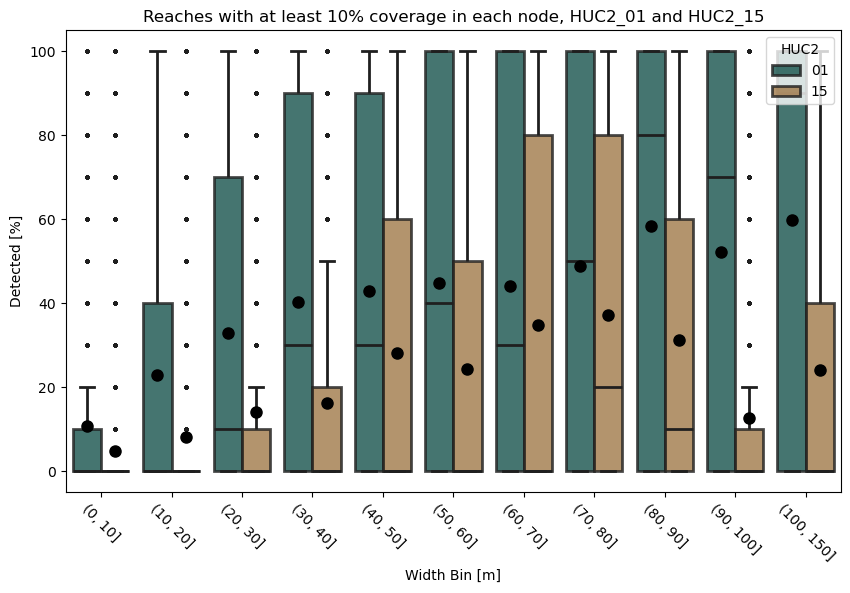

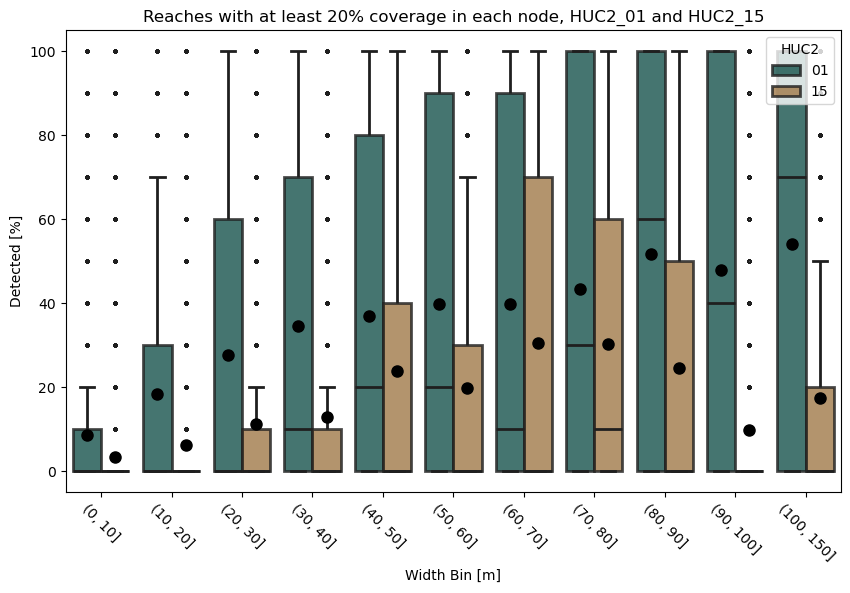

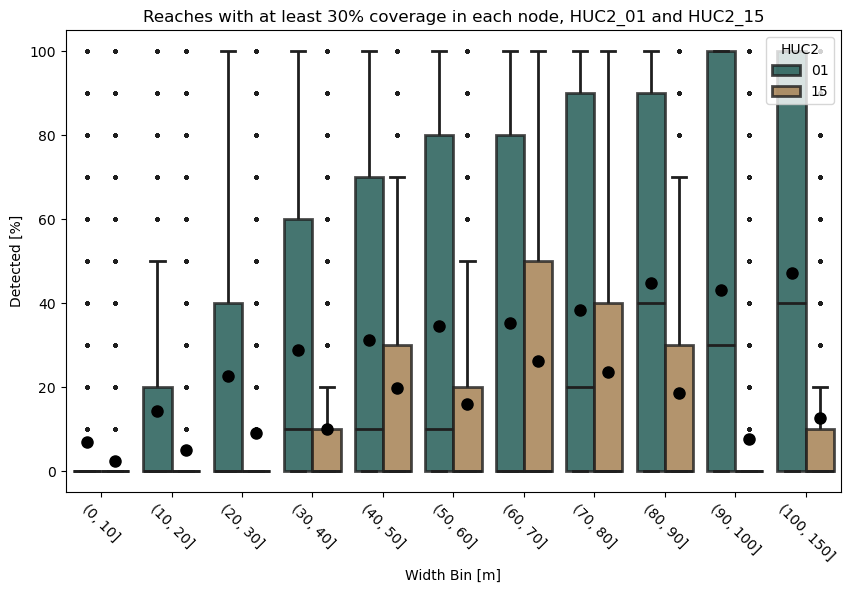

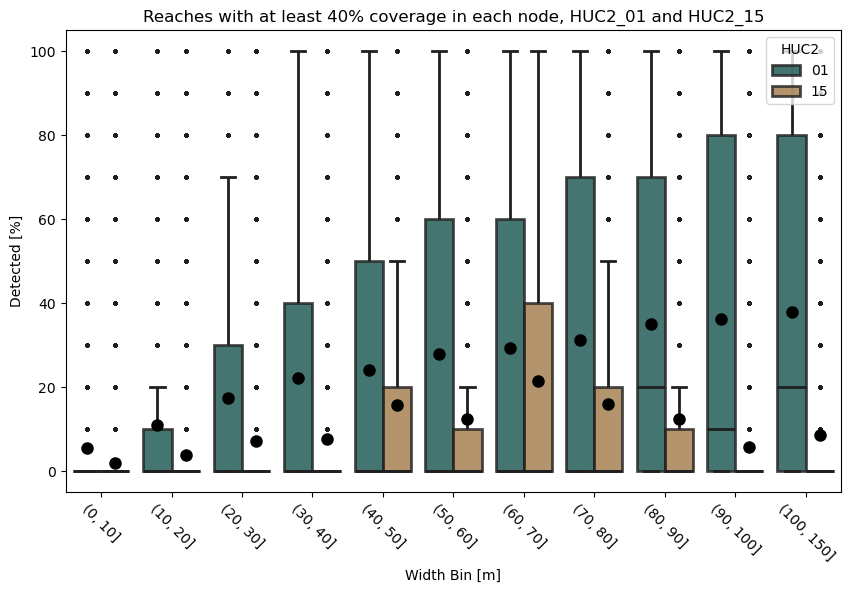

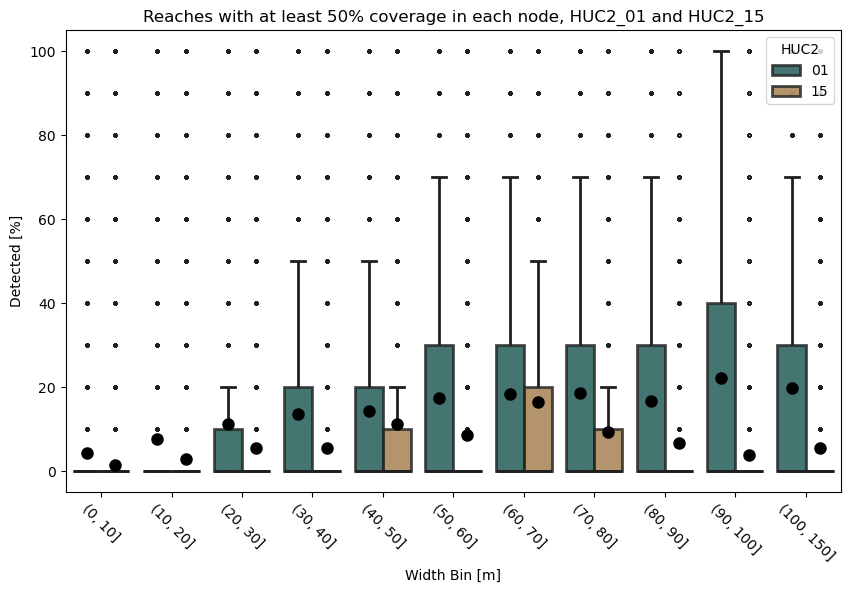

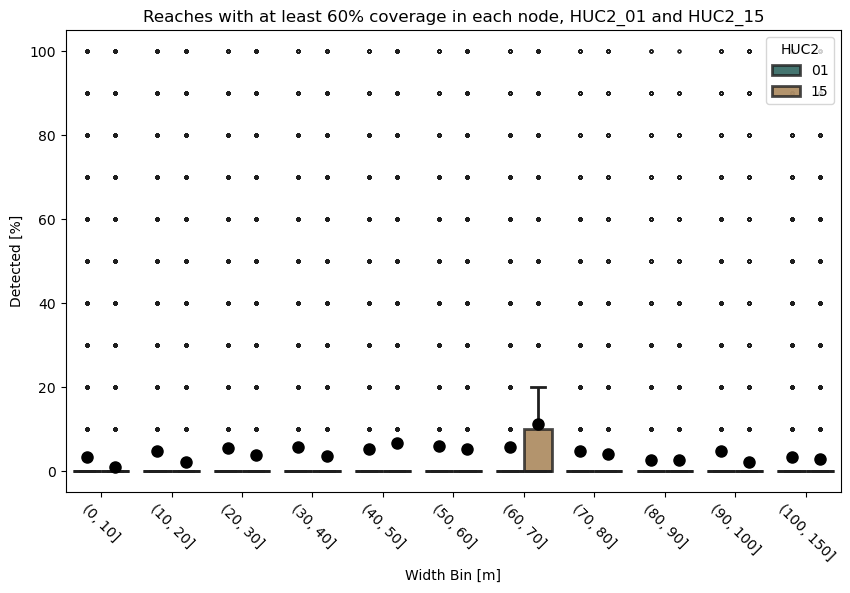

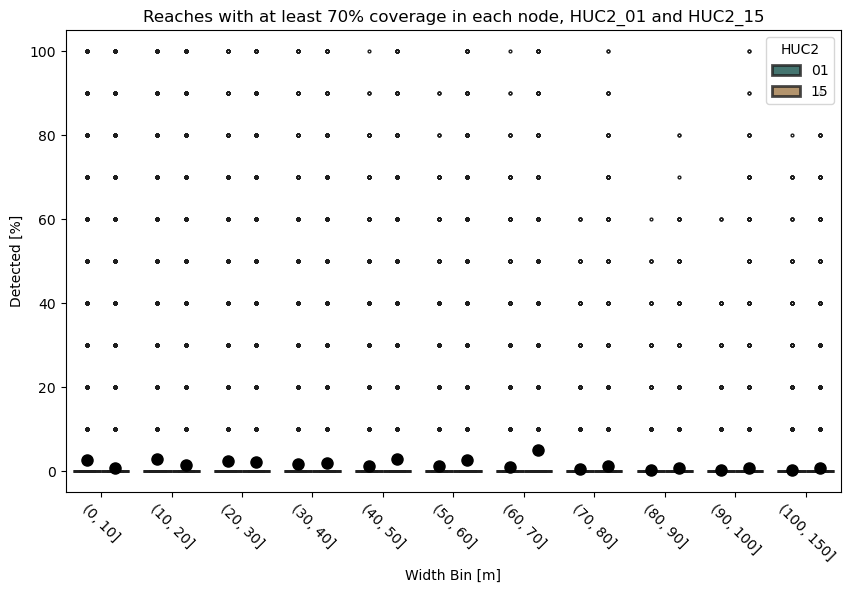

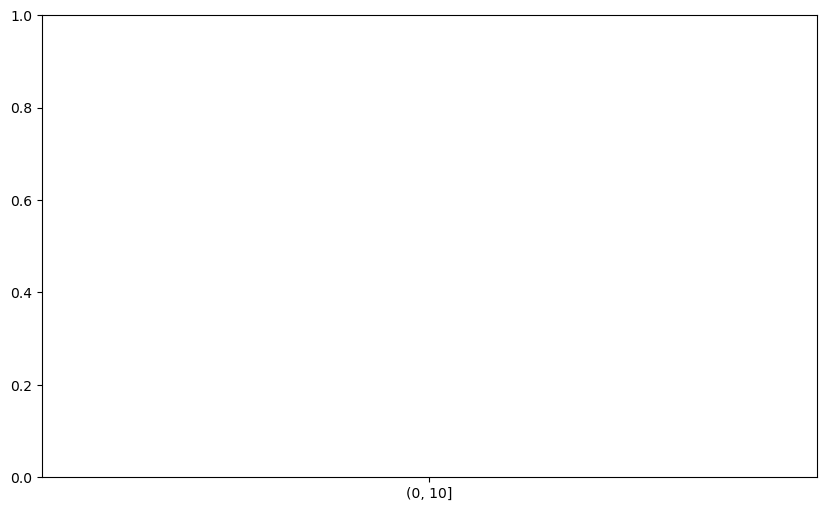

In [15]:
for i in range(len(thresholds)):

    # Get ne reaches at 10% threshold
    ddf_ne_thresh = ddf_ne[(ddf_ne['threshold'] == thresholds[i])]
    ne = ddf_ne_thresh.compute().drop(columns=['NHDPlusID']).reset_index()
    ne = ne.drop(columns=['index', 'threshold'])
    ne['coverage'] = ne['coverage']*100
    ne['huc2'] = '01'

    # Get sw reaches at 10% threshold
    ddf_sw_thresh = ddf_sw[(ddf_sw['threshold'] == thresholds[i])]
    sw = ddf_sw_thresh.compute().drop(columns=['NHDPlusID']).reset_index()
    sw = sw.drop(columns=['index', 'threshold'])
    sw['coverage'] = sw['coverage']*100
    sw['huc2'] = '15'

    combo = pd.concat(objs=[ne, sw], axis=0).reset_index()

    del ne, sw

    percent = str(int(thresholds[i]*100))

    fig, ax = plt.subplots(figsize=(10,6))
    sns.boxplot(x='Bin', y='coverage', hue='huc2',
                data=combo, order=order,
                palette=palette_two,
                legend=True,
                saturation=1, showmeans=True,
                fliersize=2, linewidth=2,
                boxprops=dict(alpha=0.8),
                meanprops={'marker':'o',
                           'markerfacecolor':'k',
                           'markeredgecolor':'k',
                           'markersize':'8'})

    plt.legend(title='HUC2', loc='upper right')

    plt.title('Reaches with at least ' + percent +'% coverage in each node, HUC2_01 and HUC2_15')
    plt.xlabel('Width Bin [m]')
    plt.ylabel('Detected [%]')
    plt.xticks(rotation=-45)

    plt.savefig('./figures_for_2025_03_06/threshold_huc2_01_and_huc_15_mean_' + percent + '.png')

### Combined

In [ ]:
for i in range(len(thresholds)):
    # Make combined dataframe
    ddf_combo = dd.concat(dfs=[ddf_ne, ddf_sw], axis=0)

    # Get combined reaches at 10% threshold
    ddf_combo = ddf_combo[(ddf_combo['threshold'] == thresholds[i])]
    combo = ddf_combo.compute().drop(columns=['NHDPlusID']).reset_index()
    combo = combo.drop(columns=['index', 'threshold'])
    combo['coverage'] = combo['coverage']*100
    # combo['huc2'] = '01, 15'

    percent = str(int(thresholds[i]*100))

    fig, ax = plt.subplots(figsize=(10,6))
    sns.boxplot(x='Bin', y='coverage',
                data=combo,
                order=order,
                color=color[2],
                saturation=1, showmeans=True,
                fliersize=2, linewidth=2,
                boxprops=dict(alpha=0.8),
                meanprops={'marker':'o',
                           'markerfacecolor':'k',
                           'markeredgecolor':'k',
                           'markersize':'8'})

    plt.title('Reaches with at least ' + percent +'% coverage in each node, HUC2_01 and HUC2_15')
    plt.xticks(rotation=-45)

    plt.xlabel('Width Bin [m]')
    plt.ylabel('Detected [%]')

    plt.savefig('./figures_for_2025_03_06/threshold_combined_mean_' + percent + '.png')

In [ ]:
del combo